In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pickle
from PIL import Image

In [0]:
#!pip install tensorflow==2.0

In [5]:
tf.__version__

'2.2.0'

In [0]:
#max_length of_train_sequences
max_length=46

# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
len_tokenizer_word_index=26555
vocab_size = len_tokenizer_word_index + 1
len_img_name_train=80000
num_steps = len_img_name_train // BATCH_SIZE
# Shape of the vector extracted from mobilenetv2 is (49, 1792)
# These two variables represent that vector shape
features_shape = 1792
attention_features_shape = 49

In [0]:

def evaluateTest(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = D.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = E(img_tensor_val)
    infile = open('tokenizer.pickle','rb')
    toketokenizer= pickle.load(infile)
    infile.close()
    
    dec_input = tf.expand_dims([toketokenizer.word_index["<start>"]], 0)
   # print(tokenizer.word_index["<start>"])
    result = []
    print("SHAPES", dec_input.shape, features.shape, hidden.shape)
    for i in range(max_length):
        predictions, hidden, attention_weights = D(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        #HERE
        result.append(toketokenizer.index_word[predicted_id])
#HERE
        if toketokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [8]:
%cd "drive/My Drive/weights"

/content/drive/My Drive/weights


In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim
       
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
        
class BahdanauAttentionTest(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttentionTest, self).__init__()
    C = tf.keras.initializers.Constant
    w1, w2, w3, w4, w5, w6 = [np.load("decoder_layer_weights/layer_%s_%s_weights_%s.npy" %(4, "bahdanau_attention", j)) \
                                  for j in range(6)]
    self.W1 = tf.keras.layers.Dense(units, kernel_initializer=C(w1), bias_initializer=C(w2))
    self.W2 = tf.keras.layers.Dense(units, kernel_initializer=C(w3), bias_initializer=C(w4))
    self.V = tf.keras.layers.Dense(1, kernel_initializer=C(w5), bias_initializer=C(w6))

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
  
    context_vector = attention_weights * features
    
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class RNN_DecoderTest(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_DecoderTest, self).__init__()
    self.units = units

    C = tf.keras.initializers.Constant
    w_emb = np.load("decoder_layer_weights/layer_%s_%s_weights_%s.npy" %(0, "embedding", 0))
    w_gru_1, w_gru_2, w_gru_3 = [np.load("decoder_layer_weights/layer_%s_%s_weights_%s.npy" %(1, "gru", j)) for j in range(3)]
    w1, w2 = [np.load("decoder_layer_weights/layer_%s_%s_weights_%s.npy" %(2, "dense_1", j)) for j in range(2)]
    w3, w4 = [np.load("decoder_layer_weights/layer_%s_%s_weights_%s.npy" %(3, "dense_2", j)) for j in range(2)]

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=C(w_emb))
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   kernel_initializer=C(w_gru_1),
                                   recurrent_initializer=C(w_gru_2),
                                   bias_initializer=C(w_gru_3)
                                   )
    self.fc1 = tf.keras.layers.Dense(self.units, kernel_initializer=C(w1), bias_initializer=C(w2))
    self.fc2 = tf.keras.layers.Dense(vocab_size, kernel_initializer=C(w3), bias_initializer=C(w4))

    self.attention = BahdanauAttentionTest(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
 

In [10]:
%cd weights

[Errno 2] No such file or directory: 'weights'
/content/drive/My Drive/weights


In [0]:
#encoder = CNN_EncoderTest(embedding_dim)
E = CNN_Encoder(embedding_dim)
E.build(input_shape=(49,1792))
E.load_weights("encoder_weights_100k_ar.h5")
D = RNN_DecoderTest(embedding_dim, units, vocab_size)


In [12]:
 image_model=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',alpha=1.4 )
 new_input=image_model.input
 hidden_layer=image_model.layers[-1].output
 image_features_extract_model=tf.keras.Model(new_input,hidden_layer)

17833984/17831080 [==============================] - 0s 0us/step


In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img) 
    return img, image_path

In [14]:
%cd ..

/content/drive/My Drive


SHAPES (1, 1) (1, 49, 256) (1, 512)
Prediction Caption: شارع المدينة المزدحم مع العديد من السيارات المتوقفة في الشارع <end>


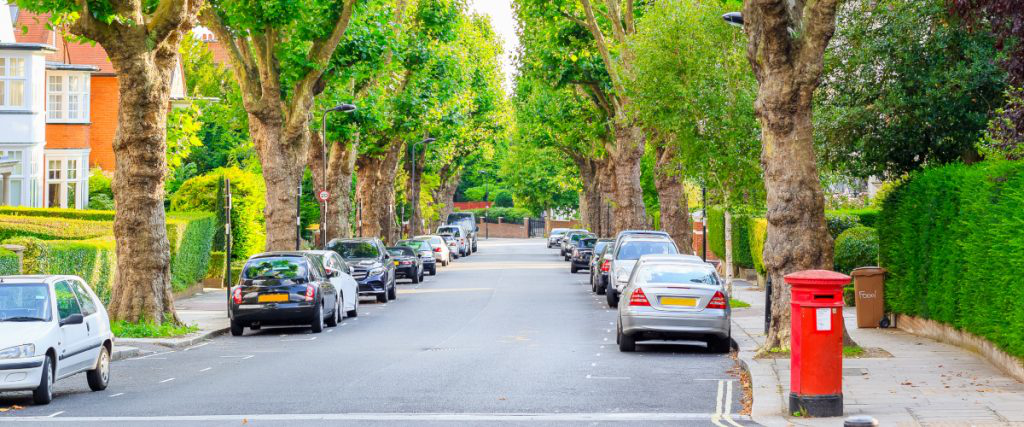

In [15]:
image_path = 'test0.jpg'

result, attention_plot = evaluateTest(image_path)
print ('Prediction Caption:', ' '.join(result))
#plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)